In [12]:
import desiutil
from desispec.io import read_spectra

from glob import glob

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('font', size =16)

In [27]:
coadds = sorted(glob('/global/project/projectdirs/desi/spectro/redux/daily/tiles/68000/20200314/coadd*.fits'))
coadds

['/global/project/projectdirs/desi/spectro/redux/daily/tiles/68000/20200314/coadd-0-68000-20200314.fits',
 '/global/project/projectdirs/desi/spectro/redux/daily/tiles/68000/20200314/coadd-1-68000-20200314.fits',
 '/global/project/projectdirs/desi/spectro/redux/daily/tiles/68000/20200314/coadd-2-68000-20200314.fits',
 '/global/project/projectdirs/desi/spectro/redux/daily/tiles/68000/20200314/coadd-3-68000-20200314.fits',
 '/global/project/projectdirs/desi/spectro/redux/daily/tiles/68000/20200314/coadd-4-68000-20200314.fits',
 '/global/project/projectdirs/desi/spectro/redux/daily/tiles/68000/20200314/coadd-5-68000-20200314.fits',
 '/global/project/projectdirs/desi/spectro/redux/daily/tiles/68000/20200314/coadd-6-68000-20200314.fits',
 '/global/project/projectdirs/desi/spectro/redux/daily/tiles/68000/20200314/coadd-7-68000-20200314.fits',
 '/global/project/projectdirs/desi/spectro/redux/daily/tiles/68000/20200314/coadd-8-68000-20200314.fits',
 '/global/project/projectdirs/desi/spectro/red

In [23]:
spectra = read_spectra(coadds[5])

In [24]:
spectra.fibermap

TARGETID,PETAL_LOC,DEVICE_LOC,LOCATION,FIBER,FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,PMRA_IVAR,PMDEC_IVAR,REF_EPOCH,LAMBDA_REF,FA_TARGET,FA_TYPE,OBJTYPE,FIBERASSIGN_X,FIBERASSIGN_Y,NUMTARGET,PRIORITY,SUBPRIORITY,OBSCONDITIONS,NUMOBS_MORE,RELEASE,BRICKID,BRICKNAME,BRICK_OBJID,MORPHTYPE,TARGET_RA_IVAR,TARGET_DEC_IVAR,EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,FRACFLUX_G,FRACFLUX_R,FRACFLUX_Z,FRACMASKED_G,FRACMASKED_R,FRACMASKED_Z,FRACIN_G,FRACIN_R,FRACIN_Z,NOBS_G,NOBS_R,NOBS_Z,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,ALLMASK_G,ALLMASK_R,ALLMASK_Z,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,WISEMASK_W1,WISEMASK_W2,MASKBITS,FRACDEV,FRACDEV_IVAR,SHAPEDEV_R,SHAPEDEV_E1,SHAPEDEV_E2,SHAPEDEV_R_IVAR,SHAPEDEV_E1_IVAR,SHAPEDEV_E2_IVAR,SHAPEEXP_R,SHAPEEXP_E1,SHAPEEXP_E2,SHAPEEXP_R_IVAR,SHAPEEXP_E1_IVAR,SHAPEEXP_E2_IVAR,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_BP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_RP_MEAN_MAG,GAIA_PHOT_RP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_RP_EXCESS_FACTOR,GAIA_ASTROMETRIC_EXCESS_NOISE,GAIA_DUPLICATED_SOURCE,GAIA_ASTROMETRIC_SIGMA5D_MAX,GAIA_ASTROMETRIC_PARAMS_SOLVED,PARALLAX,PARALLAX_IVAR,PHOTSYS,CMX_TARGET,PRIORITY_INIT,NUMOBS_INIT,HPXPIXEL,BLOBDIST,FIBERFLUX_IVAR_G,FIBERFLUX_IVAR_R,FIBERFLUX_IVAR_Z,DESI_TARGET,BGS_TARGET,MWS_TARGET,NUM_ITER,FIBER_X,FIBER_Y,MEAN_DELTA_X,MEAN_DELTA_Y,FIBER_RA,FIBER_DEC,COADD_NUMEXP,RMS_DELTA_X,RMS_DELTA_Y,FIRST_FIBER,LAST_FIBER,NUM_FIBER
int64,int16,int32,int64,int32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int64,uint8,bytes3,float32,float32,int16,int32,float64,int32,int64,int16,int32,bytes8,int32,bytes4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,uint8,uint8,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,bytes2,float32,float32,float32,float32,float32,float32,float32,float32,bool,float32,bool,float32,float32,bytes1,int64,int64,int64,int64,float32,float32,float32,float32,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,int16,float64,float64,int64,int64,int64
35191273983837955,5,0,5000,2819,0,214.71118145057977,53.5066368200524,0.0,0.0,0.0,0.0,0.0,5400.0,1024,1,TGT,5.66584,25.91031,0,4000,0.7865038309667101,65535,100,8001,596964,2145p535,1795,DEV,16783869000.0,8283028000.0,0.009548602,0.6706713,2.5063455,9.716256,128.19687,46.86248,12.337572,0.97212994,0.98113984,0.9894063,0.025858326,0.011803517,0.0058240355,0.09783286,0.08710469,0.07503739,0.94864583,0.9495984,0.9380679,3,3,3,509.22064,227.92136,62.29358,389.1496,151.66571,39.56111,27.799143,16.42065,10.990248,324.72778,4.1846333,0.81088394,0.0017669984,2.5028297e-05,0.9983831,0.9990067,0.99978805,0.99991995,0,0,0,0.17955045,0.6709926,2.601212,0.17955045,0.6709926,2.601212,0,0,0,1.0,1.0,2.0518203,0.45499414,-0.16254026,104.24136,514.6608,313.9769,0.0,0.0,0.0,0.0,0.0,0.0,0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,0.0,True,0.0,0.0,N,1024,3200,2,11427,0.0,0.0,0.0,0.0,0,0,0,3,5.667,25.884,0.002,0.0025,0.0,0.0,2,0.00447213595499958,0.006041522986797286,2819,2819,1
35191273983839156,5,3,5003,2817,0,214.69246409846934,53.59605624666174,-4.2116075,-2.0572152,3.1168807,3.8480656,2015.5,5400.0,36028797018968097,1,TGT,8.403388,47.663918,0,5000,0.5624272060927766,65535,100,8001,596964,2145p535,2996,PSF,130721776000000.0,161053940000000

In [25]:
ra, dec = [spectra.fibermap['TARGET_{}'.format(_)] for _ in ['RA', 'DEC']]
x,  y   = [spectra.fibermap['FIBERASSIGN_{}'.format(_)] for _ in 'XY']

[None]

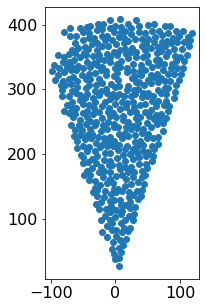

In [26]:
fig, ax = plt.subplots(1,1, figsize=(6,5))
ax.scatter(x, y)
ax.set(aspect='equal')